In [70]:
import os
from os import listdir
import re
import pandas as pd
import json
import numpy as np
from pandas_profiling import ProfileReport
import pandas_profiling as pp
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from kneed import KneeLocator 
import pickle
from scipy import stats
from sklearn.linear_model  import  LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

In [ ]:
pip install xgboost

In [2]:
#code to get the train data files
os.chdir('../')
root_dir=os.path.dirname(os.path.abspath('PhishingDomainDetection'))
path=os.path.join(root_dir,'Batch_Training_DataSet')
train_data_files=[f for f in os.listdir(path)]
train_data_files



['dataset_full.csv']

In [3]:
#validate the file name patter
manual_regex= "dataset_[a-z0-9*]+.csv"
for f in train_data_files:
    if(re.match(manual_regex,f)):
        print('the file name pattern matched')


the file name pattern matched


In [4]:
#get the train dataset schema values
with open('training_schema.json','r') as f:
    dic=json.load(f)
    no_of_cloumns=dic['NoOfColumns']
    col_names=dic['columnnames']

no_of_cloumns
col_names

{'qty_dot_url': 'Integer',
 'qty_hyphen_url': 'Integer',
 'qty_underline_url': 'Integer',
 'qty_slash_url': 'Integer',
 'qty_questionmark_url': 'Integer',
 'qty_equal_url': 'Integer',
 'qty_at_url': 'Integer',
 'qty_and_url': 'Integer',
 'qty_exclamation_url': 'Integer',
 'qty_space_url': 'Integer',
 'qty_tilde_url': 'Integer',
 'qty_comma_url': 'Integer',
 'qty_plus_url': 'Integer',
 'qty_asterisk_url': 'Integer',
 'qty_hashtag_url': 'Integer',
 'qty_dollar_url': 'Integer',
 'qty_percent_url': 'Integer',
 'qty_tld_url': 'Integer',
 'length_url': 'Integer',
 'qty_dot_domain': 'Integer',
 'qty_hyphen_domain': 'Integer',
 'qty_underline_domain': 'Integer',
 'qty_slash_domain': 'Integer',
 'qty_questionmark_domain': 'Integer',
 'qty_equal_domain': 'Integer',
 'qty_at_domain': 'Integer',
 'qty_and_domain': 'Integer',
 'qty_exclamation_domain': 'Integer',
 'qty_space_domain': 'Integer',
 'qty_tilde_domain': 'Integer',
 'qty_comma_domain': 'Integer',
 'qty_plus_domain': 'Integer',
 'qty_aste

In [5]:
#validate the number of columns in the train dataset file
#remove the data set values with whole column as null
for f in train_data_files:
    csv=pd.read_csv(path+'/'+f)
    if csv.shape[1]==no_of_cloumns:
        print(f'the number of columns matched for the dataset {f}')
        count=0
        for columns in csv:
            if((len(csv[columns])-csv[columns].count())==len(csv[columns])):
                count+=1
                print('there are missing values in the whole column for '+columns)
            else:
                print('there are no missing values for the whole column '+columns)
        print(f'the total missing values columns are {count}')

    

the number of columns matched for the dataset dataset_full.csv
there are no missing values for the whole column qty_dot_url
there are no missing values for the whole column qty_hyphen_url
there are no missing values for the whole column qty_underline_url
there are no missing values for the whole column qty_slash_url
there are no missing values for the whole column qty_questionmark_url
there are no missing values for the whole column qty_equal_url
there are no missing values for the whole column qty_at_url
there are no missing values for the whole column qty_and_url
there are no missing values for the whole column qty_exclamation_url
there are no missing values for the whole column qty_space_url
there are no missing values for the whole column qty_tilde_url
there are no missing values for the whole column qty_comma_url
there are no missing values for the whole column qty_plus_url
there are no missing values for the whole column qty_asterisk_url
there are no missing values for the whole 

In [6]:
data=pd.DataFrame(csv)

In [7]:
data

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,3,0,0,1,0,0,0,0,0,0,...,1,2,0,892,0,0,0,0,0,1
1,5,0,1,3,0,3,0,2,0,0,...,1,2,1,9540,1,0,0,0,0,1
2,2,0,0,1,0,0,0,0,0,0,...,1,2,3,589,1,0,0,0,0,0
3,4,0,2,5,0,0,0,0,0,0,...,1,2,0,292,1,0,0,0,0,1
4,2,0,0,0,0,0,0,0,0,0,...,1,2,1,3597,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88642,3,1,0,0,0,0,0,0,0,0,...,1,3,1,3597,0,0,0,0,0,0
88643,2,0,0,0,0,0,0,0,0,0,...,1,2,2,591,0,2,0,0,0,0
88644,2,1,0,5,0,0,0,0,0,0,...,1,2,5,14391,1,0,0,0,0,1
88645,2,0,0,1,0,0,0,0,0,0,...,1,1,1,52,1,0,0,0,0,1


In [ ]:
profile = pp.ProfileReport(data)

In [ ]:
profile.to_file("output.html")

In [8]:
#get all the cloumns and the data types for the columns
column_data_types=data.dtypes
column_data_types
total_columns=data.columns
total_columns
dtypes_count=data.dtypes.value_counts()
dtypes_count

int64      111
float64      1
dtype: int64

In [9]:
#data preprocessing
#drop the columns which has zero values for the whole column
all_zero_columnNames = data.any().to_dict()

all_zero_columnNames

{'qty_dot_url': True,
 'qty_hyphen_url': True,
 'qty_underline_url': True,
 'qty_slash_url': True,
 'qty_questionmark_url': True,
 'qty_equal_url': True,
 'qty_at_url': True,
 'qty_and_url': True,
 'qty_exclamation_url': True,
 'qty_space_url': True,
 'qty_tilde_url': True,
 'qty_comma_url': True,
 'qty_plus_url': True,
 'qty_asterisk_url': True,
 'qty_hashtag_url': True,
 'qty_dollar_url': True,
 'qty_percent_url': True,
 'qty_tld_url': True,
 'length_url': True,
 'qty_dot_domain': True,
 'qty_hyphen_domain': True,
 'qty_underline_domain': True,
 'qty_slash_domain': False,
 'qty_questionmark_domain': False,
 'qty_equal_domain': False,
 'qty_at_domain': True,
 'qty_and_domain': False,
 'qty_exclamation_domain': False,
 'qty_space_domain': False,
 'qty_tilde_domain': False,
 'qty_comma_domain': False,
 'qty_plus_domain': False,
 'qty_asterisk_domain': False,
 'qty_hashtag_domain': False,
 'qty_dollar_domain': False,
 'qty_percent_domain': False,
 'qty_vowels_domain': True,
 'domain_leng

In [10]:
#get the column names list which has all zeros or null values
allzero_colms =[]
for column in data:
    if data[column].isna().all() or (data[column] ==0).all():
        allzero_colms.append(column)
print(allzero_colms)

['qty_slash_domain', 'qty_questionmark_domain', 'qty_equal_domain', 'qty_and_domain', 'qty_exclamation_domain', 'qty_space_domain', 'qty_tilde_domain', 'qty_comma_domain', 'qty_plus_domain', 'qty_asterisk_domain', 'qty_hashtag_domain', 'qty_dollar_domain', 'qty_percent_domain']


In [11]:
# the columns to be removed as they have same value are 
# ['qty_slash_domain', 'qty_questionmark_domain', 'qty_equal_domain', 'qty_and_domain', 'qty_exclamation_domain', 'qty_space_domain', 'qty_tilde_domain', 'qty_comma_domain', 'qty_plus_domain', 'qty_asterisk_domain', 'qty_hashtag_domain', 'qty_dollar_domain', 'qty_percent_domain']

In [12]:
#remove the columns which has all zeros or null from dataframe
data_allnonzeros=data.drop(allzero_colms,axis=1)
data_allnonzeros

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,3,0,0,1,0,0,0,0,0,0,...,1,2,0,892,0,0,0,0,0,1
1,5,0,1,3,0,3,0,2,0,0,...,1,2,1,9540,1,0,0,0,0,1
2,2,0,0,1,0,0,0,0,0,0,...,1,2,3,589,1,0,0,0,0,0
3,4,0,2,5,0,0,0,0,0,0,...,1,2,0,292,1,0,0,0,0,1
4,2,0,0,0,0,0,0,0,0,0,...,1,2,1,3597,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88642,3,1,0,0,0,0,0,0,0,0,...,1,3,1,3597,0,0,0,0,0,0
88643,2,0,0,0,0,0,0,0,0,0,...,1,2,2,591,0,2,0,0,0,0
88644,2,1,0,5,0,0,0,0,0,0,...,1,2,5,14391,1,0,0,0,0,1
88645,2,0,0,1,0,0,0,0,0,0,...,1,1,1,52,1,0,0,0,0,1


In [13]:
total_columns=data_allnonzeros.columns
total_columns

Index(['qty_dot_url', 'qty_hyphen_url', 'qty_underline_url', 'qty_slash_url',
       'qty_questionmark_url', 'qty_equal_url', 'qty_at_url', 'qty_and_url',
       'qty_exclamation_url', 'qty_space_url', 'qty_tilde_url',
       'qty_comma_url', 'qty_plus_url', 'qty_asterisk_url', 'qty_hashtag_url',
       'qty_dollar_url', 'qty_percent_url', 'qty_tld_url', 'length_url',
       'qty_dot_domain', 'qty_hyphen_domain', 'qty_underline_domain',
       'qty_at_domain', 'qty_vowels_domain', 'domain_length', 'domain_in_ip',
       'server_client_domain', 'qty_dot_directory', 'qty_hyphen_directory',
       'qty_underline_directory', 'qty_slash_directory',
       'qty_questionmark_directory', 'qty_equal_directory', 'qty_at_directory',
       'qty_and_directory', 'qty_exclamation_directory', 'qty_space_directory',
       'qty_tilde_directory', 'qty_comma_directory', 'qty_plus_directory',
       'qty_asterisk_directory', 'qty_hashtag_directory',
       'qty_dollar_directory', 'qty_percent_directory',

In [14]:
total_columns.size

99

In [15]:
#check for invalida values in column
data_allnonzeros =data_allnonzeros.replace("?",np.nan)
data_allnonzeros

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,3,0,0,1,0,0,0,0,0,0,...,1,2,0,892,0,0,0,0,0,1
1,5,0,1,3,0,3,0,2,0,0,...,1,2,1,9540,1,0,0,0,0,1
2,2,0,0,1,0,0,0,0,0,0,...,1,2,3,589,1,0,0,0,0,0
3,4,0,2,5,0,0,0,0,0,0,...,1,2,0,292,1,0,0,0,0,1
4,2,0,0,0,0,0,0,0,0,0,...,1,2,1,3597,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88642,3,1,0,0,0,0,0,0,0,0,...,1,3,1,3597,0,0,0,0,0,0
88643,2,0,0,0,0,0,0,0,0,0,...,1,2,2,591,0,2,0,0,0,0
88644,2,1,0,5,0,0,0,0,0,0,...,1,2,5,14391,1,0,0,0,0,1
88645,2,0,0,1,0,0,0,0,0,0,...,1,1,1,52,1,0,0,0,0,1


In [16]:
#check if null are present after replacing ? with null and return the csv file with the columns which has null values
null_present=False
cols_with_missing_values=[]
cols = data_allnonzeros.columns
val=data_allnonzeros.isna().sum()
for i in range(len(val)):
    if val[i]>0:
        null_present=True
        cols_with_missing_values.append(cols[i])
if null_present:
    print('there are null values in the data set')
    null_data=pd.DataFrame()
    null_data['columns']=data_allnonzeros.columns
    null_data['total missing values'] =np.asarray(data_allnonzeros.isna().sum())
    null_data.to_csv('null_values.csv')
else:
    print('there are no null values in the dataset')
    
        
        

there are no null values in the dataset


In [17]:
# get the columns with categorical 
cat_columns=data_allnonzeros.select_dtypes(include=['category','object']).dtypes
cat_columns

Series([], dtype: object)

In [18]:
#drop the columns with zero standard deviation
preprocessed_data=data_allnonzeros.drop(data_allnonzeros.std()[data_allnonzeros.std() == 0].index.values,axis=1)

In [19]:
len(preprocessed_data.columns)

99

In [20]:
#drop the columns with constant values
preprocessed_data =preprocessed_data.drop(preprocessed_data.columns[preprocessed_data.nunique()==1],axis=1)

In [21]:
#find correlation between features
cor_matrix = preprocessed_data.corr().abs()
cor_matrix

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
qty_dot_url,1.000000,0.109737,0.127851,0.246201,0.409549,0.498531,0.169224,0.550918,0.004187,0.000405,...,0.054120,0.014089,0.049845,0.012300,0.065105,0.051842,0.004035,0.002490,0.059222,0.171128
qty_hyphen_url,0.109737,1.000000,0.213589,0.304762,0.061247,0.175158,0.041982,0.127984,0.018253,0.018090,...,0.029222,0.032991,0.027048,0.031027,0.009113,0.001930,0.002939,0.006875,0.010346,0.200382
qty_underline_url,0.127851,0.213589,1.000000,0.246653,0.067009,0.334635,0.056885,0.256192,0.062300,0.000767,...,0.004625,0.023962,0.007595,0.027089,0.012809,0.013864,0.001823,0.003421,0.012158,0.191151
qty_slash_url,0.246201,0.304762,0.246653,1.000000,0.182759,0.287043,0.102281,0.202511,0.025946,0.015055,...,0.046034,0.032416,0.045904,0.021936,0.018282,0.047873,0.005406,0.009470,0.001125,0.699061
qty_questionmark_url,0.409549,0.061247,0.067009,0.182759,1.000000,0.461202,0.126747,0.467278,0.017859,0.004359,...,0.025966,0.003923,0.032176,0.006653,0.040856,0.024214,0.011679,0.010029,0.012847,0.111694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
qty_redirects,0.051842,0.001930,0.013864,0.047873,0.024214,0.043475,0.017895,0.030949,0.004488,0.006923,...,0.274887,0.051420,0.133489,0.007329,0.306561,1.000000,0.038041,0.033091,0.049475,0.061775
url_google_index,0.004035,0.002939,0.001823,0.005406,0.011679,0.000349,0.001903,0.000335,0.000811,0.000336,...,0.043826,0.042233,0.022227,0.007591,0.026047,0.038041,1.000000,0.628815,0.001785,0.008986
domain_google_index,0.002490,0.006875,0.003421,0.009470,0.010029,0.004701,0.001889,0.001886,0.001076,0.000446,...,0.039959,0.040542,0.023628,0.008920,0.027592,0.033091,0.628815,1.000000,0.000045,0.000794
url_shortened,0.059222,0.010346,0.012158,0.001125,0.012847,0.011855,0.005330,0.009989,0.002503,0.001038,...,0.059500,0.084482,0.013533,0.031268,0.037850,0.049475,0.001785,0.000045,1.000000,0.099250


In [22]:
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
upper_tri


C:\Users\nagat\AppData\Local\Temp\ipykernel_15280\936715272.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))


,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
qty_dot_url,NaN,0.109737,0.127851,0.246201,0.409549,0.498531,0.169224,0.550918,0.004187,0.000405,...,0.054120,0.014089,0.049845,0.012300,0.065105,0.051842,0.004035,0.002490,0.059222,0.171128
qty_hyphen_url,NaN,NaN,0.213589,0.304762,0.061247,0.175158,0.041982,0.127984,0.018253,0.018090,...,0.029222,0.032991,0.027048,0.031027,0.009113,0.001930,0.002939,0.006875,0.010346,0.200382
qty_underline_url,NaN,NaN,NaN,0.246653,0.067009,0.334635,0.056885,0.256192,0.062300,0.000767,...,0.004625,0.023962,0.007595,0.027089,0.012809,0.013864,0.001823,0.003421,0.012158,0.191151
qty_slash_url,NaN,NaN,NaN,NaN,0.182759,0.287043,0.102281,0.202511,0.025946,0.015055,...,0.046034,0.032416,0.045904,0.021936,0.018282,0.047873,0.005406,0.009470,0.001125,0.699061
qty_questionmark_url,NaN,NaN,NaN,NaN,NaN,0.461202,0.126747,0.467278,0.017859,0.004359,...,0.025966,0.003923,0.032176,0.006653,0.040856,0.024214,0.011679,0.010029,0.012847,0.111694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
qty_redirects,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.038041,0.033091,0.049475,0.061775
url_google_index,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.628815,0.001785,0.008986
domain_google_index,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000045,0.000794
url_shortened,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.099250


In [23]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(); print(to_drop)



['qty_slash_directory', 'qty_equal_directory', 'qty_and_directory', 'qty_exclamation_directory', 'qty_space_directory', 'qty_tilde_directory', 'qty_comma_directory', 'qty_plus_directory', 'qty_hashtag_directory', 'qty_dollar_directory', 'qty_slash_file', 'qty_questionmark_file', 'qty_equal_file', 'qty_at_file', 'qty_and_file', 'qty_exclamation_file', 'qty_space_file', 'qty_tilde_file', 'qty_comma_file', 'qty_plus_file', 'qty_hashtag_file', 'qty_dollar_file', 'qty_equal_params', 'qty_space_params', 'qty_tilde_params', 'qty_comma_params', 'qty_plus_params', 'qty_asterisk_params', 'qty_hashtag_params', 'qty_dollar_params', 'tld_present_params', 'qty_params']


In [24]:
data_removal_corr= preprocessed_data.drop(to_drop, axis=1)
print(); print(data_removal_corr.head())


   qty_dot_url  qty_hyphen_url  qty_underline_url  qty_slash_url  \
0            3               0                  0              1   
1            5               0                  1              3   
2            2               0                  0              1   
3            4               0                  2              5   
4            2               0                  0              0   

   qty_questionmark_url  qty_equal_url  qty_at_url  qty_and_url  \
0                     0              0           0            0   
1                     0              3           0            2   
2                     0              0           0            0   
3                     0              0           0            0   
4                     0              0           0            0   

   qty_exclamation_url  qty_space_url  ...  qty_ip_resolved  qty_nameservers  \
0                    0              0  ...                1                2   
1                    0     

In [25]:
data_removal_corr.describe()

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
count,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,...,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.000000,88647.00000,88647.000000,88647.000000,88647.000000
mean,2.191343,0.328810,0.113879,1.281781,0.009329,0.205861,0.022133,0.140885,0.002944,0.001015,...,1.136564,2.772412,1.742428,6159.877514,0.506447,0.343903,0.00141,0.002019,0.005482,0.345720
std,1.235636,1.119286,0.657767,1.893929,0.112568,0.954272,0.279652,0.924864,0.087341,0.072653,...,0.895146,1.322999,1.706705,11465.583810,0.499961,0.783892,0.05864,0.063250,0.073841,0.475605
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.00000,-1.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2.000000,1.000000,292.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2.000000,1.000000,2029.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,4.000000,2.000000,10798.000000,1.000000,1.000000,0.00000,0.000000,0.000000,1.000000
max,24.000000,35.000000,21.000000,44.000000,9.000000,23.000000,43.000000,26.000000,10.000000,9.000000,...,24.000000,20.000000,20.000000,604800.000000,1.000000,17.000000,1.00000,1.000000,1.000000,1.000000


C:\Users\nagat\AppData\Local\Temp\ipykernel_15280\2011412317.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


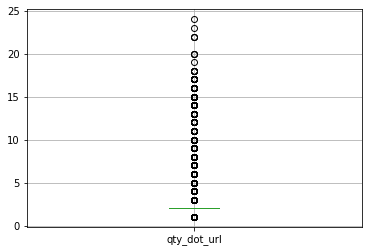

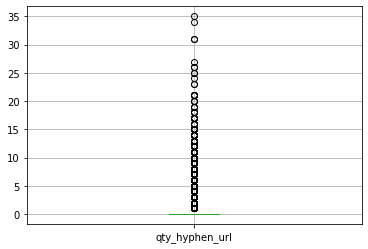

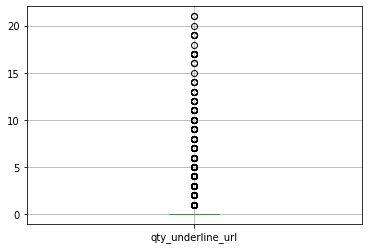

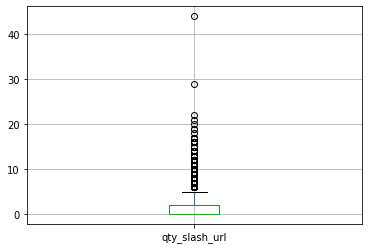

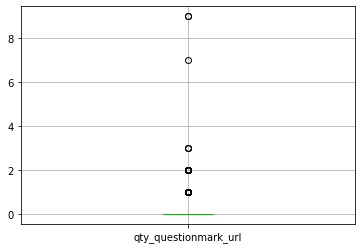

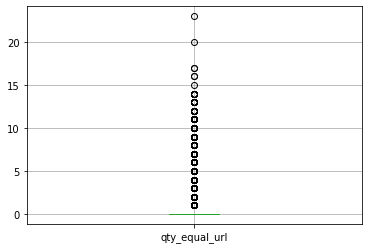

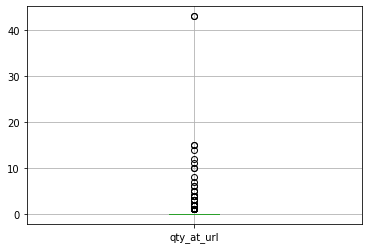

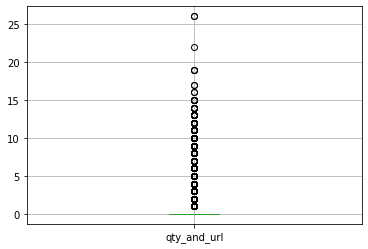

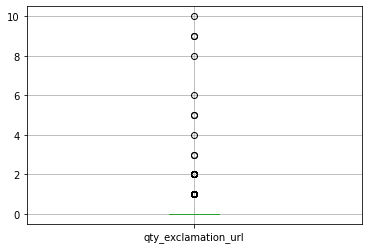

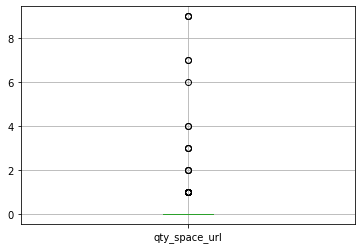

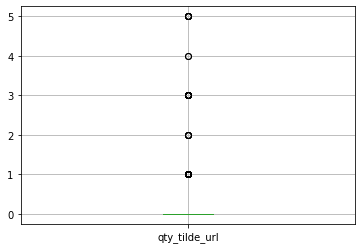

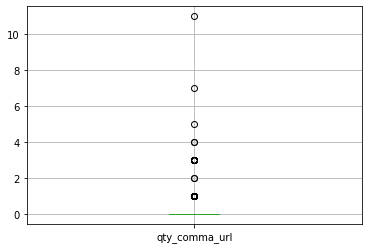

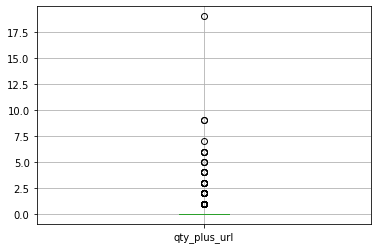

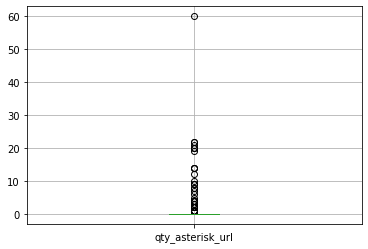

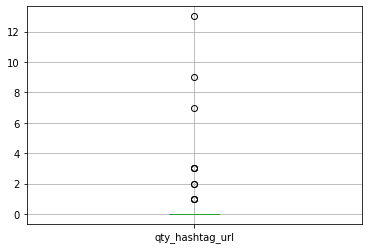

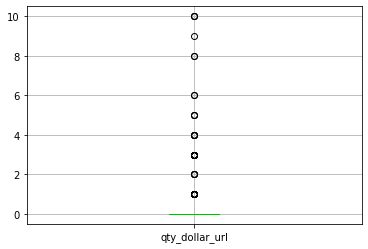

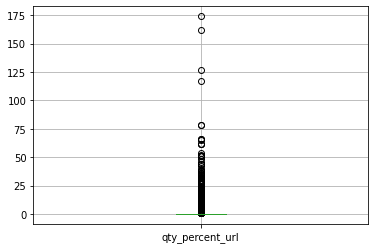

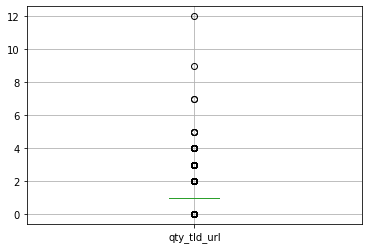

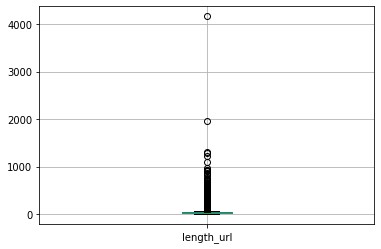

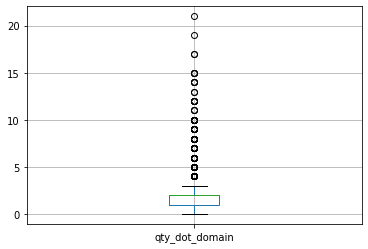

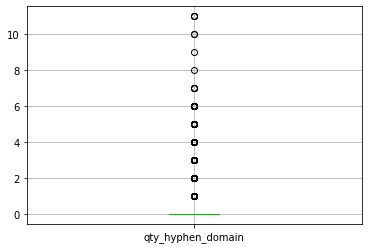

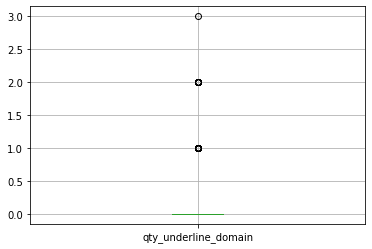

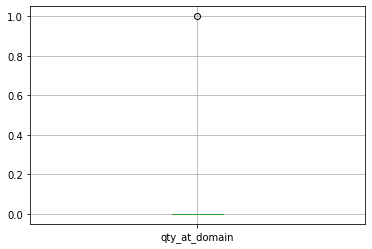

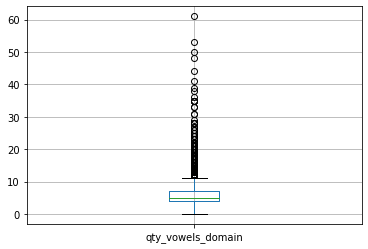

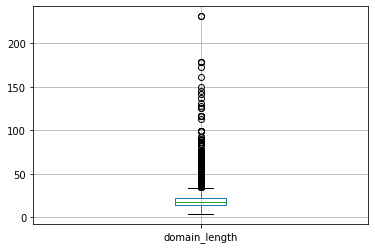

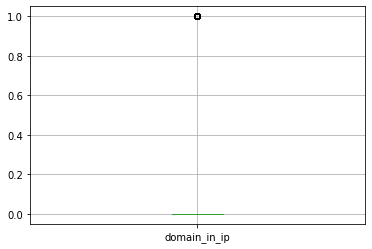

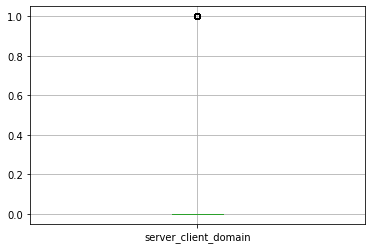

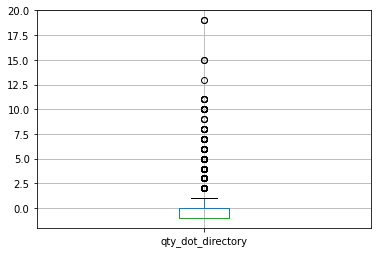

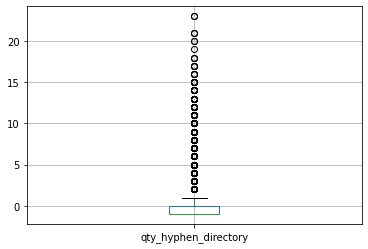

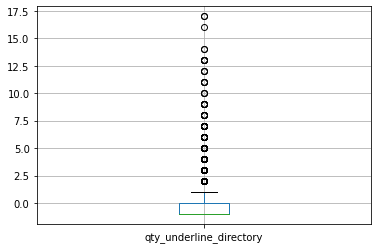

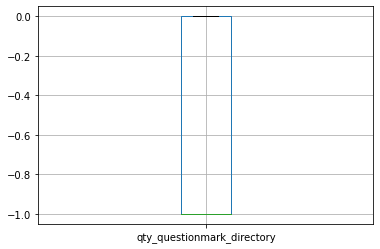

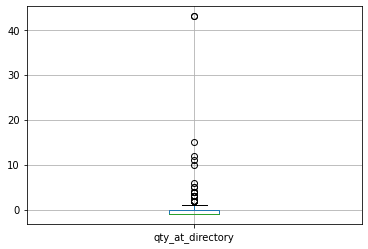

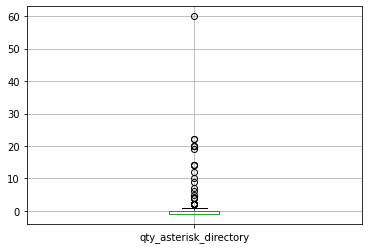

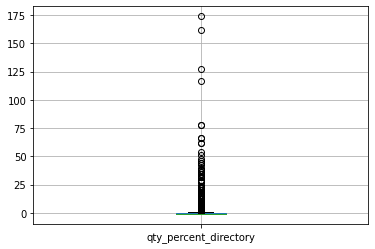

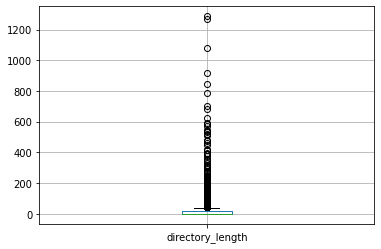

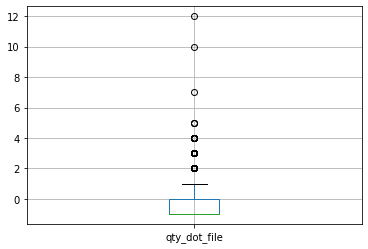

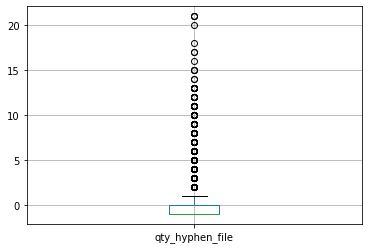

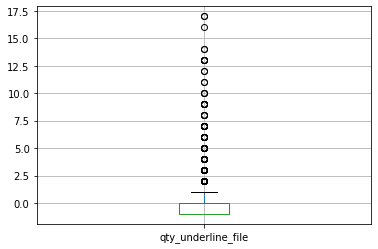

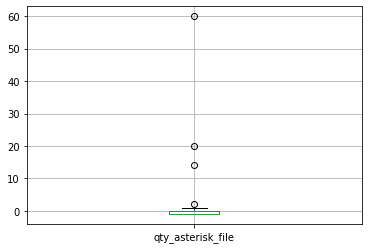

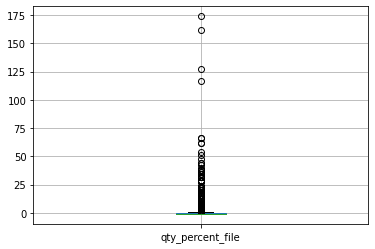

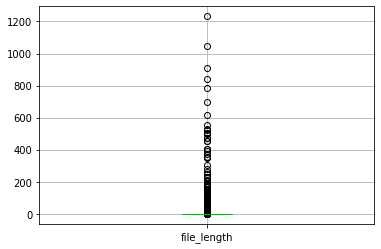

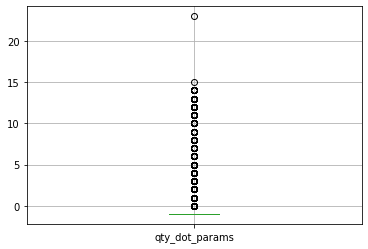

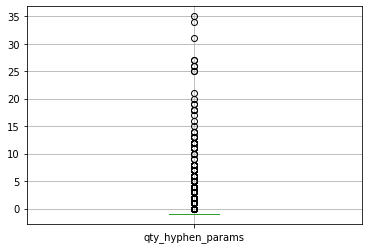

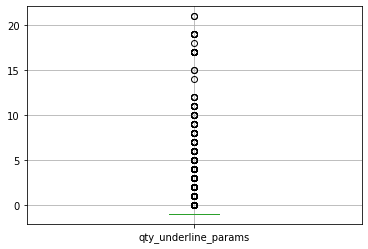

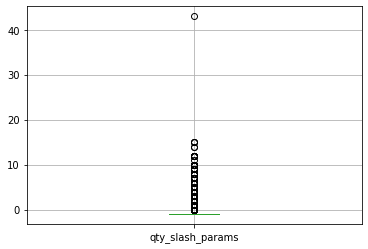

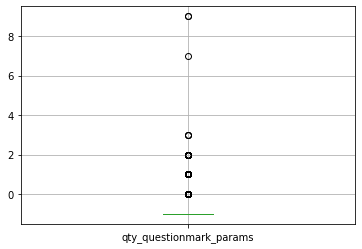

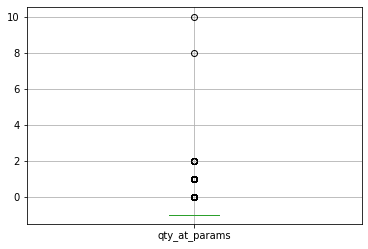

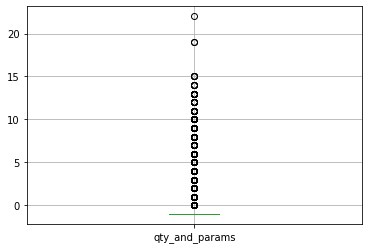

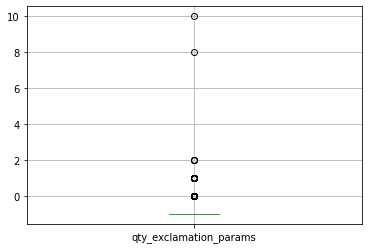

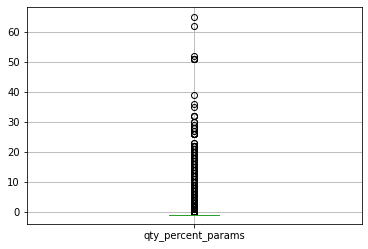

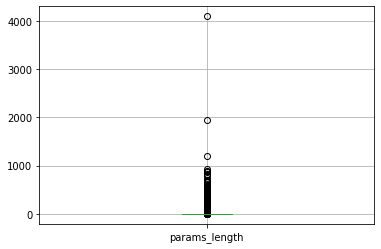

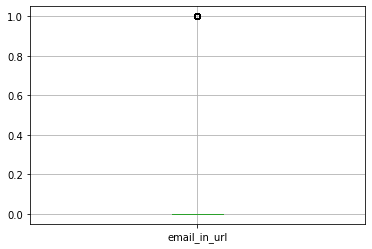

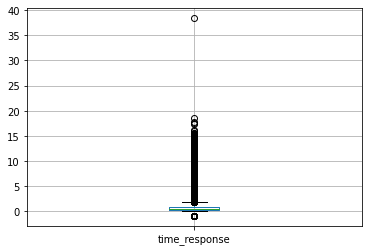

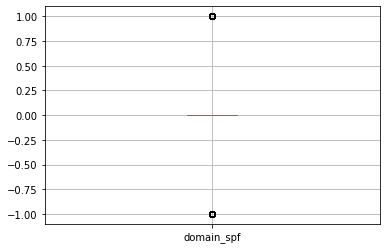

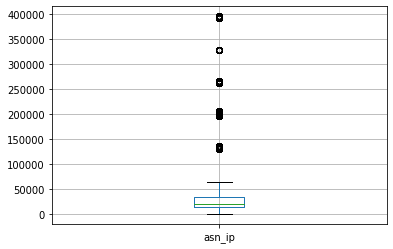

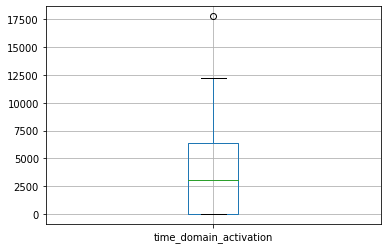

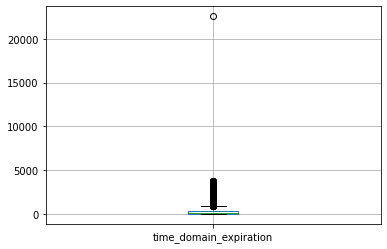

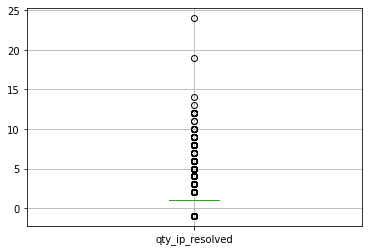

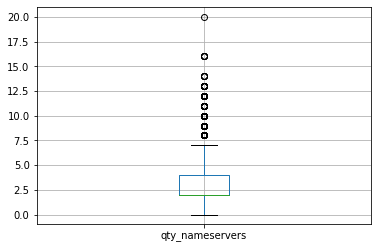

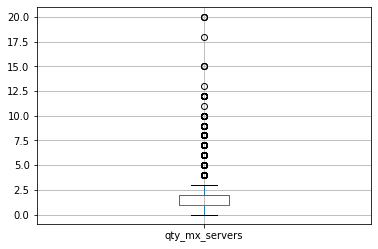

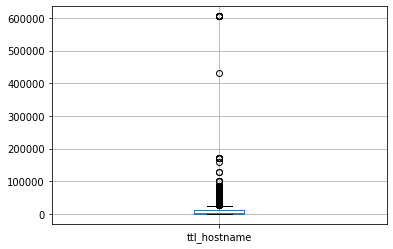

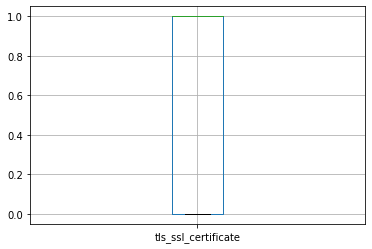

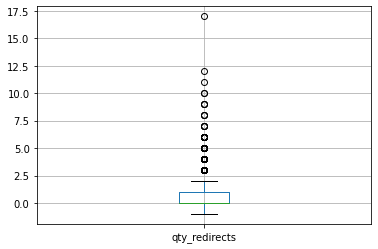

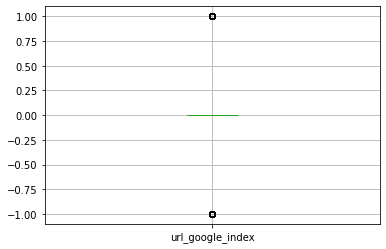

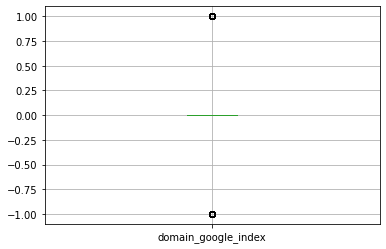

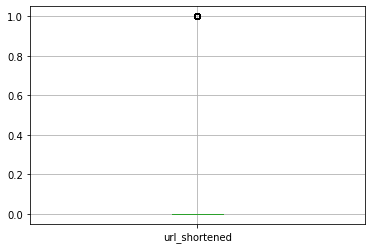

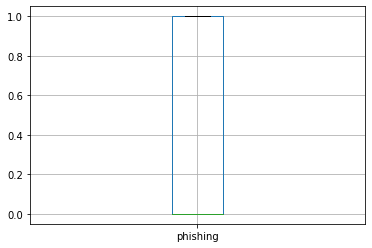

In [26]:
for column in data_removal_corr:
    plt.figure()
    data_removal_corr.boxplot([column])

In [27]:
z=np.abs(stats.zscore(data_removal_corr))
print(z)

       qty_dot_url  qty_hyphen_url  qty_underline_url  qty_slash_url  \
0         0.654449        0.293769           0.173130       0.148782   
1         2.273058        0.293769           1.347173       0.907230   
2         0.154855        0.293769           0.173130       0.148782   
3         1.463754        0.293769           2.867476       1.963241   
4         0.154855        0.293769           0.173130       0.676788   
...            ...             ...                ...            ...   
88642     0.654449        0.599663           0.173130       0.676788   
88643     0.154855        0.293769           0.173130       0.676788   
88644     0.154855        0.599663           0.173130       1.963241   
88645     0.154855        0.293769           0.173130       0.148782   
88646     0.154855        0.293769           0.173130       0.676788   

       qty_questionmark_url  qty_equal_url  qty_at_url  qty_and_url  \
0                  0.082876       0.215727    0.079144     0.152

In [28]:
print(np.where(z > 3))

(array([    1,     1,     1, ..., 88642, 88643, 88644], dtype=int64), array([17, 18, 27, ..., 17, 23, 54], dtype=int64))


In [29]:
z_p=data_removal_corr[(z < 3).all(axis=1)]

In [30]:
z_p

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,3,0,0,1,0,0,0,0,0,0,...,1,2,0,892,0,0,0,0,0,1
2,2,0,0,1,0,0,0,0,0,0,...,1,2,3,589,1,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,1,2,1,3597,0,1,0,0,0,0
5,1,0,0,2,0,0,0,0,0,0,...,1,3,3,3591,1,0,0,0,0,1
6,2,0,0,0,0,0,0,0,0,0,...,1,2,2,291,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88638,2,1,0,4,0,0,0,0,0,0,...,1,2,1,899,1,0,0,0,0,1
88639,2,0,0,0,0,0,0,0,0,0,...,1,4,2,11643,1,1,0,0,0,0
88641,2,1,0,0,0,0,0,0,0,0,...,1,2,1,146,1,2,0,0,0,0
88645,2,0,0,1,0,0,0,0,0,0,...,1,1,1,52,1,0,0,0,0,1


In [31]:
Q1=data_removal_corr.quantile(0.25)
Q3=data_removal_corr.quantile(0.75)

IQR=Q3-Q1


lowqe_bound=Q1 - 1.5 * IQR
upper_bound=Q3 + 1.5 * IQR

print(lowqe_bound,upper_bound)


IQR_p = data_removal_corr[~((data_removal_corr < lowqe_bound) |(data_removal_corr > upper_bound)).any(axis=1)]

qty_dot_url             2.0
qty_hyphen_url          0.0
qty_underline_url       0.0
qty_slash_url          -3.0
qty_questionmark_url    0.0
                       ... 
qty_redirects          -1.5
url_google_index        0.0
domain_google_index     0.0
url_shortened           0.0
phishing               -1.5
Length: 67, dtype: float64 qty_dot_url             2.0
qty_hyphen_url          0.0
qty_underline_url       0.0
qty_slash_url           5.0
qty_questionmark_url    0.0
                       ... 
qty_redirects           2.5
url_google_index        0.0
domain_google_index     0.0
url_shortened           0.0
phishing                2.5
Length: 67, dtype: float64


In [32]:
IQR_p.shape

(13438, 67)

In [33]:
IQR_p.columns

Index(['qty_dot_url', 'qty_hyphen_url', 'qty_underline_url', 'qty_slash_url',
       'qty_questionmark_url', 'qty_equal_url', 'qty_at_url', 'qty_and_url',
       'qty_exclamation_url', 'qty_space_url', 'qty_tilde_url',
       'qty_comma_url', 'qty_plus_url', 'qty_asterisk_url', 'qty_hashtag_url',
       'qty_dollar_url', 'qty_percent_url', 'qty_tld_url', 'length_url',
       'qty_dot_domain', 'qty_hyphen_domain', 'qty_underline_domain',
       'qty_at_domain', 'qty_vowels_domain', 'domain_length', 'domain_in_ip',
       'server_client_domain', 'qty_dot_directory', 'qty_hyphen_directory',
       'qty_underline_directory', 'qty_questionmark_directory',
       'qty_at_directory', 'qty_asterisk_directory', 'qty_percent_directory',
       'directory_length', 'qty_dot_file', 'qty_hyphen_file',
       'qty_underline_file', 'qty_asterisk_file', 'qty_percent_file',
       'file_length', 'qty_dot_params', 'qty_hyphen_params',
       'qty_underline_params', 'qty_slash_params', 'qty_questionmark_p

C:\Users\nagat\AppData\Local\Temp\ipykernel_15280\3447985339.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


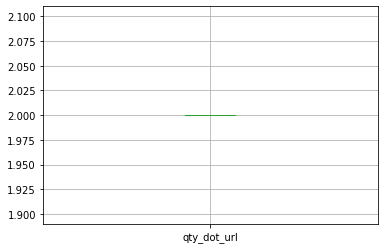

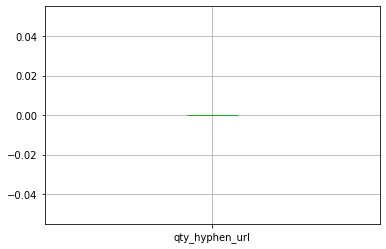

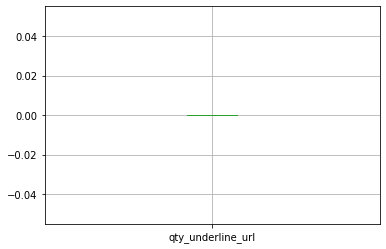

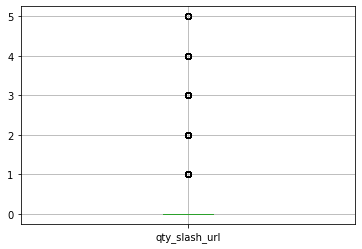

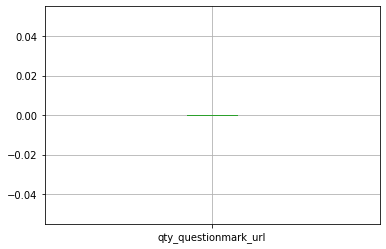

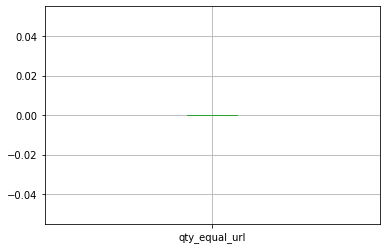

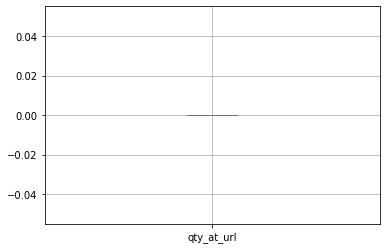

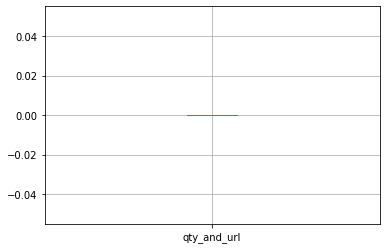

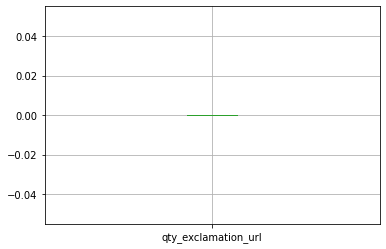

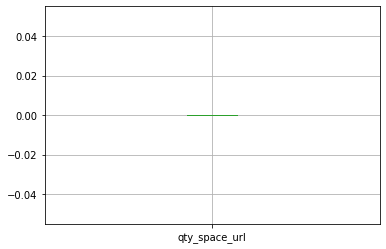

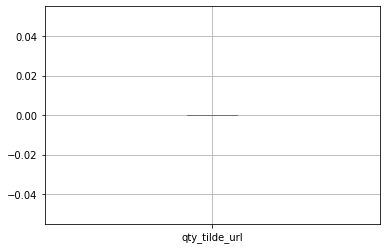

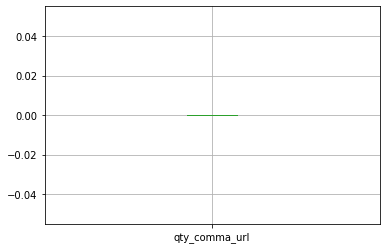

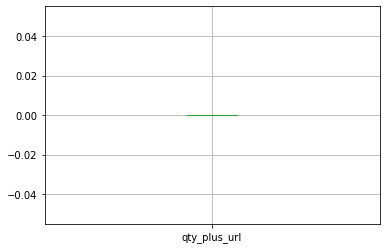

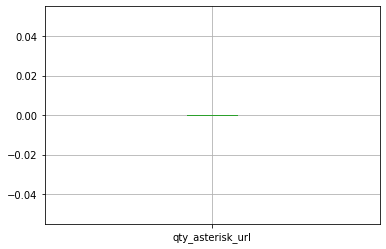

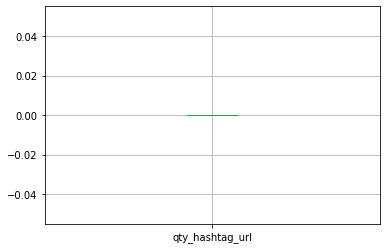

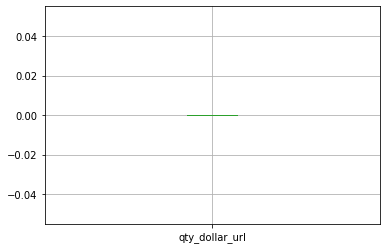

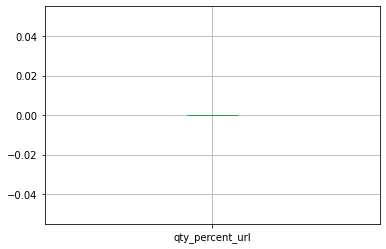

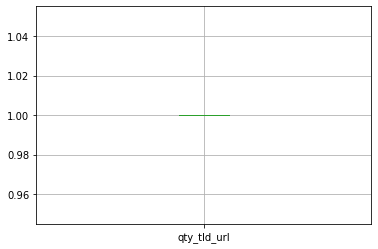

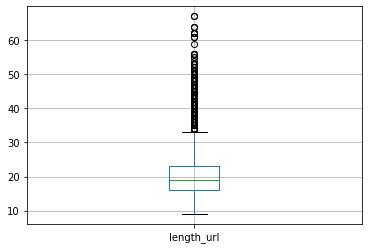

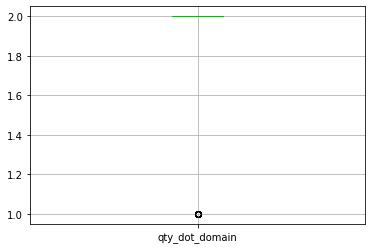

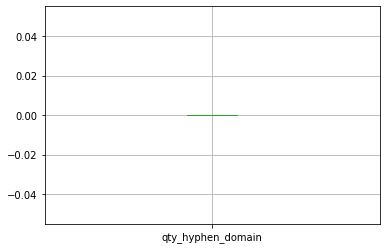

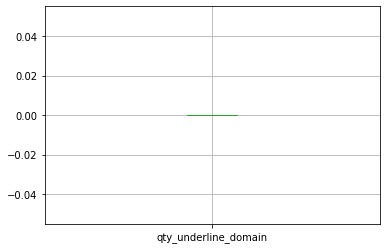

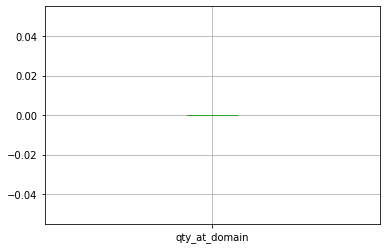

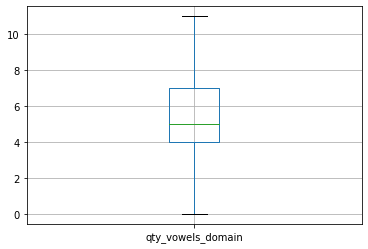

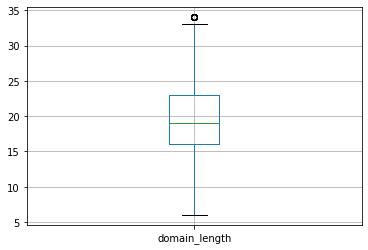

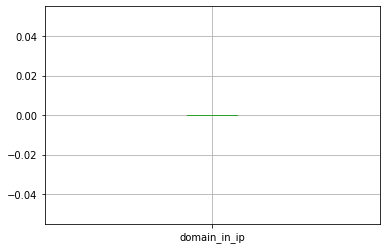

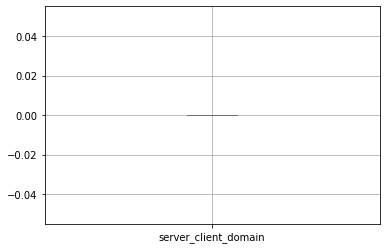

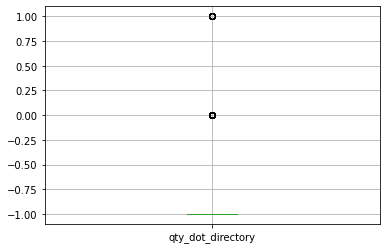

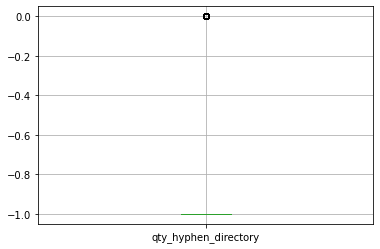

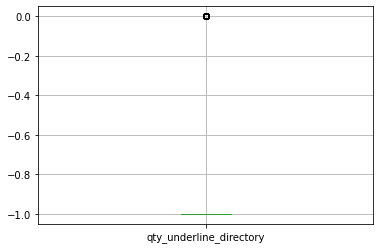

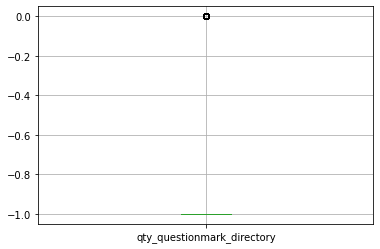

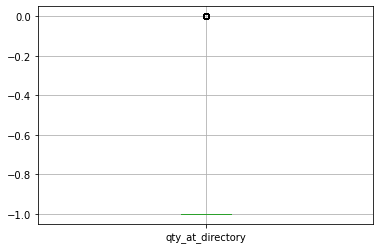

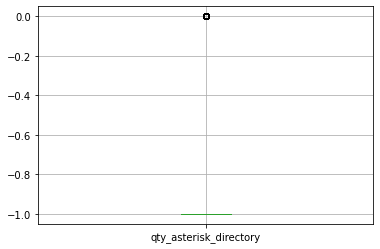

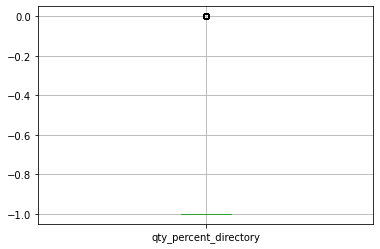

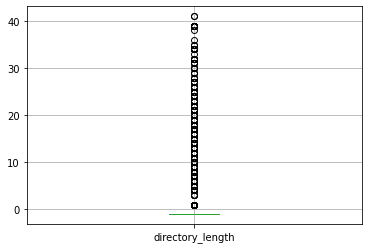

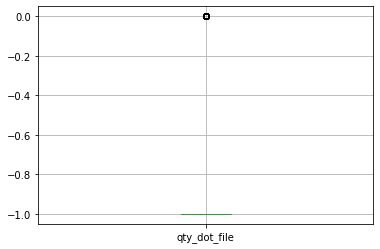

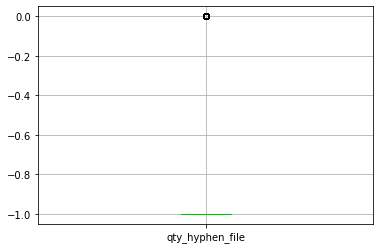

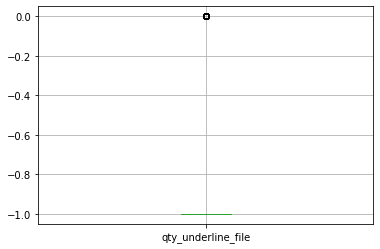

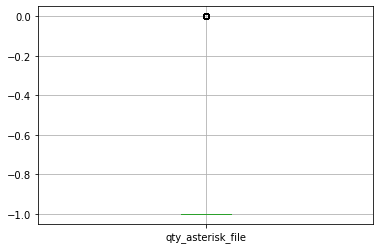

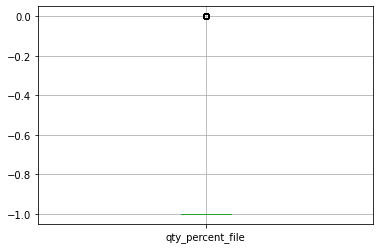

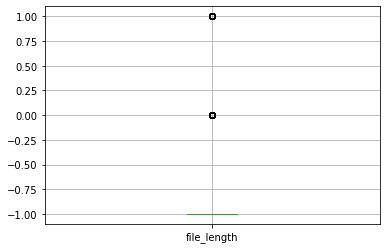

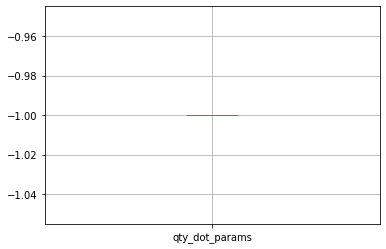

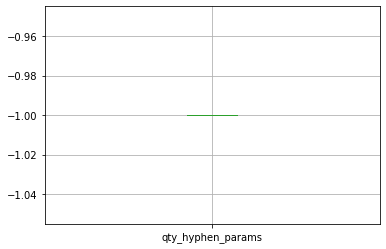

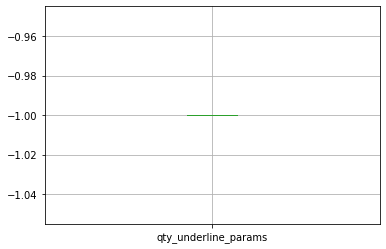

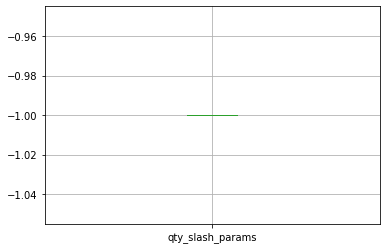

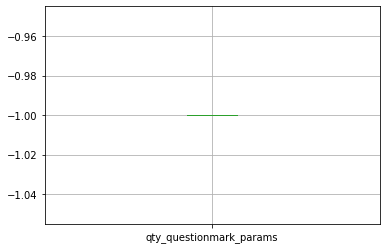

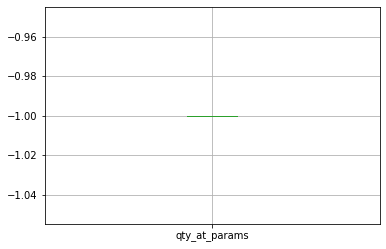

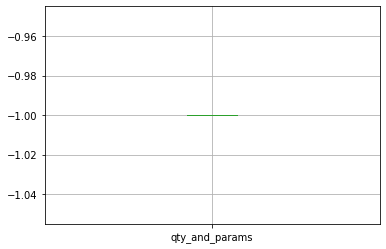

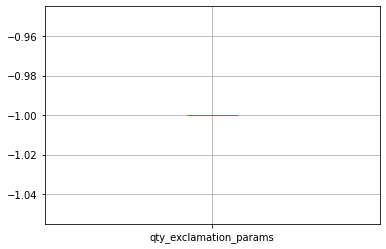

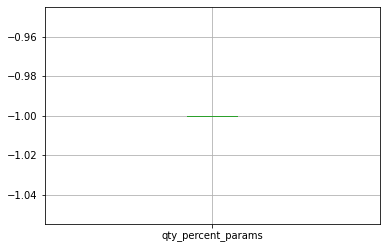

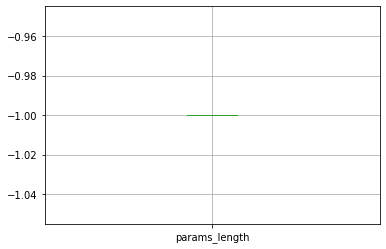

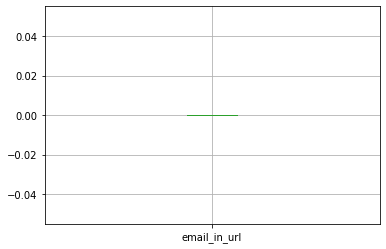

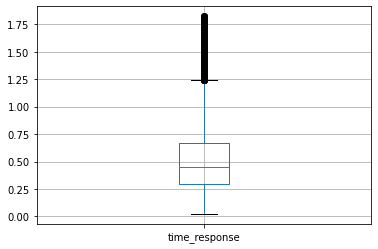

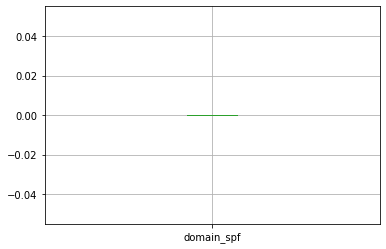

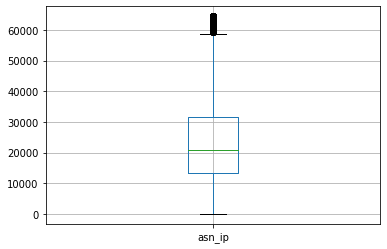

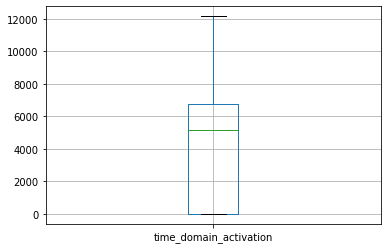

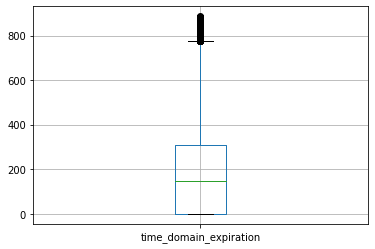

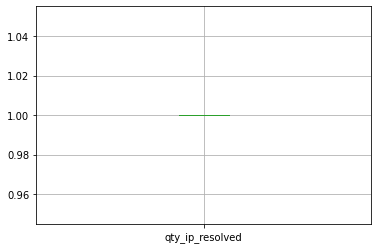

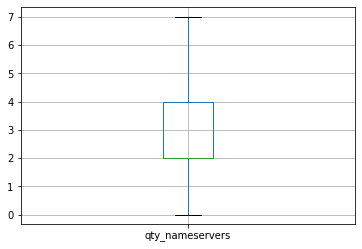

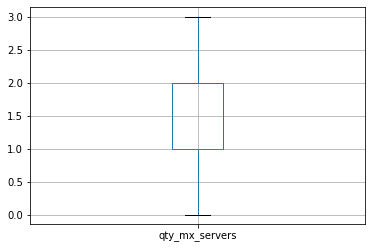

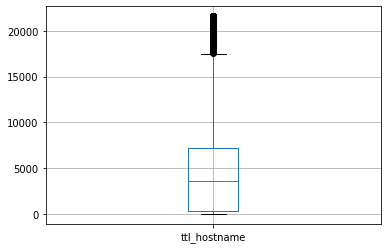

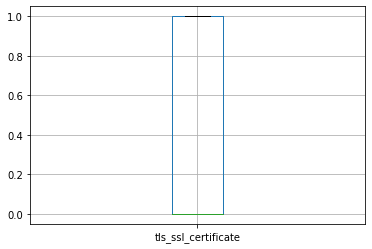

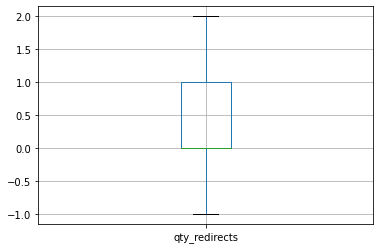

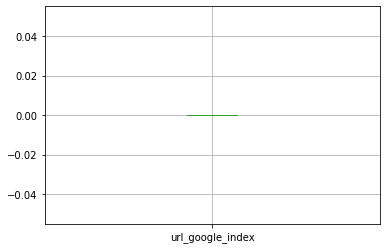

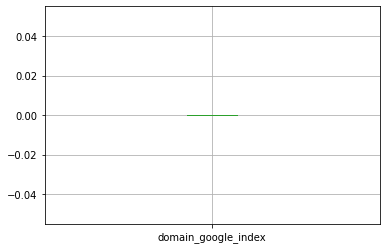

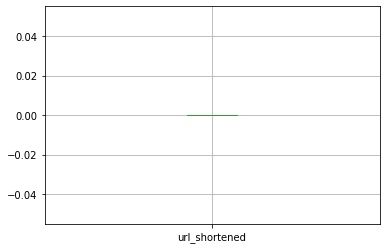

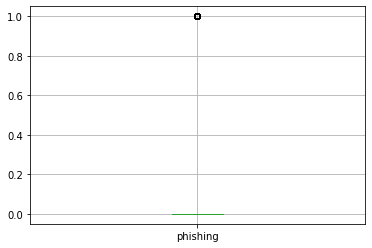

In [34]:
for column in IQR_p:
    plt.figure()
    IQR_p.boxplot([column])

In [35]:
final_training_data=pd.DataFrame(IQR_p)

In [36]:
final_training_data.shape

(13438, 67)

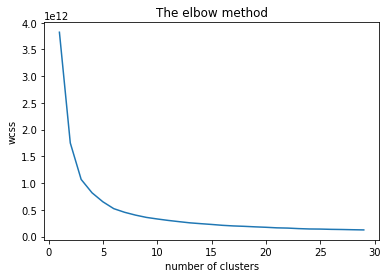

In [37]:
#creating clusters
#elbow plot
wcss=[]
for i in range(1,30):
    kmeans=KMeans(n_clusters=i,init='k-means++',random_state=42)
    kmeans.fit(final_training_data)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,30),wcss)
plt.title('The elbow method')
plt.xlabel('number of clusters')
plt.ylabel('wcss')
plt.savefig('K-Means_Elbow.PNG')

In [38]:
#no of clusters 
number_of_clusters=KneeLocator(range(1,30),wcss,curve='convex',direction='decreasing').knee
number_of_clusters

5

In [39]:
#creating clusters using k mean
kmeans = KMeans(n_clusters=number_of_clusters, init='k-means++', random_state=42)
y_kmeans=kmeans.fit_predict(final_training_data)

In [40]:
#saving model
with open('kmean_model.sav','wb') as files:
    pickle.dump(kmeans,files)


In [41]:
y_kmeans

array([4, 1, 0, ..., 1, 1, 1])

In [42]:
final_training_data['Cluster']=y_kmeans
list_of_clusters=final_training_data['Cluster'].unique()
list_of_clusters


array([4, 1, 0, 3, 2])

In [43]:
final_training_data

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing,Cluster
2,2,0,0,1,0,0,0,0,0,0,...,2,3,589,1,0,0,0,0,0,4
4,2,0,0,0,0,0,0,0,0,0,...,2,1,3597,0,1,0,0,0,0,1
6,2,0,0,0,0,0,0,0,0,0,...,2,2,291,0,0,0,0,0,0,0
8,2,0,0,0,0,0,0,0,0,0,...,4,2,3596,1,1,0,0,0,0,0
23,2,0,0,0,0,0,0,0,0,0,...,2,1,291,0,1,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88627,2,0,0,0,0,0,0,0,0,0,...,2,2,3596,0,0,0,0,0,0,2
88629,2,0,0,0,0,0,0,0,0,0,...,2,3,7200,1,1,0,0,0,0,4
88630,2,0,0,0,0,0,0,0,0,0,...,3,2,10799,1,1,0,0,0,0,1
88645,2,0,0,1,0,0,0,0,0,0,...,1,1,52,1,0,0,0,0,1,1


In [44]:
#dividing the feature and label
X=final_training_data.drop(['Cluster','phishing'],axis=1)
Y=final_training_data['phishing']
X.shape
Y.shape

(13438,)

In [45]:

#spliting the train data into train and valdiation data using train test split
# X_train_stand,X_rem_stand,Y_train_stand,Y_rem_stand = train_test_split(X,Y,train_size=0.6)
# X_val_stand,X_test_stand,Y_val_stand,Y_test_stand = train_test_split(X_rem_stand,Y_rem_stand,train_size=0.2)


In [46]:
#feature scaling
#standard scaler
stand=StandardScaler().fit(X)
X_stand=stand.transform(X)
X_stand=pd.DataFrame(X_stand)

In [68]:
#lOGISTICREGRESSION
for i in list_of_clusters:
        x_train, x_test, y_train, y_test = train_test_split(X_stand, Y, test_size=1 / 3, random_state=36)
        logr_liblinear = LogisticRegression(verbose=1,solver='liblinear')
        logr_liblinear.fit(x_train,y_train )
        y_pred = logr_liblinear.predict(x_test)
        if len(y_test.unique()) == 1:
            lgr_score = accuracy_score(y_test,y_pred)
            print('Accuracy for decision tree:' + str(lgr_score))
        else:
            lgr_score = roc_auc_score(y_test, y_pred) 
            print('AUC for decision tree:' + str(lgr_score))
                

[LibLinear]AUC for decision tree:0.8383825479765236
[LibLinear]AUC for decision tree:0.8383825479765236
[LibLinear]AUC for decision tree:0.8383825479765236
[LibLinear]AUC for decision tree:0.8383825479765236
[LibLinear]AUC for decision tree:0.8383825479765236


In [66]:
#Decisiontree
for i in list_of_clusters:
        x_train, x_test, y_train, y_test = train_test_split(X_stand, Y, test_size=1 / 3, random_state=36)
        dt_model = DecisionTreeClassifier()
        dt_model.fit(x_train, y_train)
        y_pred = dt_model.predict(x_test)
        if len(y_test.unique()) == 1:
            dcs_score = accuracy_score(y_test,y_pred)
            print('Accuracy for decision tree:' + str(dcs_score))
        else:
            dcs_score = roc_auc_score(y_test, y_pred) 
            print('AUC for decision tree:' + str(dcs_score))
                    

AUC for decision tree:0.8735072411542132
AUC for decision tree:0.8742294366284548
AUC for decision tree:0.8747109002779493
AUC for decision tree:0.8742294366284548
AUC for decision tree:0.8770561894662844


In [71]:
#NaiveBayes
for i in list_of_clusters:
        x_train, x_test, y_train, y_test = train_test_split(X_stand, Y, test_size=1 / 3, random_state=36)
        naive_bayes = GaussianNB()
        naive_bayes.fit(x_train,y_train)
        y_pred = naive_bayes.predict(x_test)
        if len(y_test.unique()) == 1:
            navby_score = accuracy_score(y_test,y_pred)
            print('Accuracy for decision tree:' + str(navby_score))
        else:
            navby_score = roc_auc_score(y_test, y_pred) 
            print('AUC for decision tree:' + str(navby_score))
                    

AUC for decision tree:0.9080389660641971
AUC for decision tree:0.9080389660641971
AUC for decision tree:0.9080389660641971
AUC for decision tree:0.9080389660641971
AUC for decision tree:0.9080389660641971


In [53]:
#XGBoost
xgb = XGBClassifier(objective='binary:logistic',n_jobs=-1)
for i in list_of_clusters:
        x_train, x_test, y_train, y_test = train_test_split(X_stand, Y, test_size=1 / 3, random_state=36)
        param_grid_xgboost = {"n_estimators": [100, 130], "criterion": ['gini', 'entropy'],"max_depth": range(8, 10, 1)}
        grid= GridSearchCV(XGBClassifier(objective='binary:logistic'),param_grid_xgboost, verbose=3,cv=5)
        grid.fit(x_train, y_train)
        criterion = grid.best_params_['criterion']
        max_depth = grid.best_params_['max_depth']
        n_estimators = grid.best_params_['n_estimators']
        xgb = XGBClassifier(criterion=criterion, max_depth=max_depth,n_estimators=n_estimators, n_jobs=-1 )
        xgb.fit(x_train, y_train)
        prediction_xgboost = xgb.predict(x_test)
        if len(y_test.unique()) == 1:
            xgboost_score = accuracy_score(y_test, prediction_xgboost)
            print('Accuracy for XGBoost:' + str(xgboost_score)) 
        else:
            xgboost_score = roc_auc_score(y_test, prediction_xgboost) 
            print('AUC for XGBoost:' + str(xgboost_score)) 
        
                    

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[18:32:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV 1/5] END criterion=gini, max_depth=8, n_estimators=100;, score=0.976 total time=   0.2s
[18:32:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV 2/5] END

[CV 2/5] END criterion=gini, max_depth=9, n_estimators=130;, score=0.978 total time=   0.3s
[18:32:54] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV 3/5] END criterion=gini, max_depth=9, n_estimators=130;, score=0.977 total time=   0.3s
[18:32:54] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you fin

[CV 3/5] END criterion=entropy, max_depth=9, n_estimators=100;, score=0.978 total time=   0.3s
[18:33:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV 4/5] END criterion=entropy, max_depth=9, n_estimators=100;, score=0.976 total time=   0.3s
[18:33:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if y

[CV 3/5] END criterion=gini, max_depth=8, n_estimators=130;, score=0.978 total time=   0.3s
[18:33:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV 4/5] END criterion=gini, max_depth=8, n_estimators=130;, score=0.975 total time=   0.3s
[18:33:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you fin

[CV 5/5] END criterion=entropy, max_depth=8, n_estimators=100;, score=0.979 total time=   0.3s
[18:33:14] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV 1/5] END criterion=entropy, max_depth=8, n_estimators=130;, score=0.976 total time=   0.4s
[18:33:14] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if y

[18:33:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


AUC for XGBoost:0.8925760077506786
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[18:33:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV 1/5] END criterion=gini, max_depth=8, n_estimators=100;, score=0.

[CV 1/5] END criterion=gini, max_depth=9, n_estimators=130;, score=0.978 total time=   0.4s
[18:33:28] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV 2/5] END criterion=gini, max_depth=9, n_estimators=130;, score=0.978 total time=   0.4s
[18:33:28] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you fin

[CV 2/5] END criterion=entropy, max_depth=9, n_estimators=100;, score=0.978 total time=   0.3s
[18:33:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV 3/5] END criterion=entropy, max_depth=9, n_estimators=100;, score=0.978 total time=   0.3s
[18:33:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if y

[CV 2/5] END criterion=gini, max_depth=8, n_estimators=130;, score=0.976 total time=   0.4s
[18:33:42] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV 3/5] END criterion=gini, max_depth=8, n_estimators=130;, score=0.978 total time=   0.4s
[18:33:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you fin

[CV 4/5] END criterion=entropy, max_depth=8, n_estimators=100;, score=0.977 total time=   0.3s
[18:33:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV 5/5] END criterion=entropy, max_depth=8, n_estimators=100;, score=0.979 total time=   0.3s
[18:33:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if y

[CV 5/5] END criterion=entropy, max_depth=9, n_estimators=130;, score=0.979 total time=   0.4s
[18:33:57] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:33:57] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


AUC for XGBoost:0.8925760077506786
Fitting 5 folds for each of 8 cand

[CV 5/5] END criterion=gini, max_depth=9, n_estimators=100;, score=0.979 total time=   0.3s
[18:34:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV 1/5] END criterion=gini, max_depth=9, n_estimators=130;, score=0.978 total time=   0.4s
[18:34:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you fin

[CV 2/5] END criterion=entropy, max_depth=9, n_estimators=100;, score=0.978 total time=   0.3s
[18:34:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV 3/5] END criterion=entropy, max_depth=9, n_estimators=100;, score=0.978 total time=   0.3s
[18:34:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "criterion" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if y

In [60]:
#SVM
sv_classifier=SVC()

for i in list_of_clusters:
        x_train, x_test, y_train, y_test = train_test_split(X_stand, Y, test_size=1 / 3, random_state=36)
        param_grid = {"kernel": ['rbf', 'sigmoid'],"C": [0.1, 0.5, 1.0],"random_state": [0, 100, 200, 300]}
        grid = GridSearchCV(estimator=sv_classifier, param_grid=param_grid, cv=5,  verbose=3)
        grid.fit(x_train, y_train)
        kernel = grid.best_params_['kernel']
        C = grid.best_params_['C']
        random_state = grid.best_params_['random_state']
        sv_classifier = SVC(kernel=kernel,C=C,random_state=random_state)
        sv_classifier.fit(x_train, y_train)
        prediction_svm=sv_classifier.predict(x_test) 
        if len(y_test.unique()) == 1:
            svm_score = accuracy_score(y_test,prediction_svm)
            print('Accuracy for SVM:' + str(svm_score))
        else:
            svm_score = roc_auc_score(y_test, prediction_svm) 
            print('AUC for SVM:' + str(svm_score))


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END .C=0.1, kernel=rbf, random_state=0;, score=0.965 total time=   0.3s
[CV 2/5] END .C=0.1, kernel=rbf, random_state=0;, score=0.965 total time=   0.3s
[CV 3/5] END .C=0.1, kernel=rbf, random_state=0;, score=0.963 total time=   0.3s
[CV 4/5] END .C=0.1, kernel=rbf, random_state=0;, score=0.968 total time=   0.3s
[CV 5/5] END .C=0.1, kernel=rbf, random_state=0;, score=0.962 total time=   0.2s
[CV 1/5] END C=0.1, kernel=rbf, random_state=100;, score=0.965 total time=   0.3s
[CV 2/5] END C=0.1, kernel=rbf, random_state=100;, score=0.965 total time=   0.2s
[CV 3/5] END C=0.1, kernel=rbf, random_state=100;, score=0.963 total time=   0.2s
[CV 4/5] END C=0.1, kernel=rbf, random_state=100;, score=0.968 total time=   0.2s
[CV 5/5] END C=0.1, kernel=rbf, random_state=100;, score=0.962 total time=   0.2s
[CV 1/5] END C=0.1, kernel=rbf, random_state=200;, score=0.965 total time=   0.2s
[CV 2/5] END C=0.1, kernel=rbf, random_st

[CV 4/5] END C=1.0, kernel=rbf, random_state=300;, score=0.972 total time=   0.2s
[CV 5/5] END C=1.0, kernel=rbf, random_state=300;, score=0.974 total time=   0.2s
[CV 1/5] END C=1.0, kernel=sigmoid, random_state=0;, score=0.901 total time=   0.1s
[CV 2/5] END C=1.0, kernel=sigmoid, random_state=0;, score=0.904 total time=   0.1s
[CV 3/5] END C=1.0, kernel=sigmoid, random_state=0;, score=0.905 total time=   0.1s
[CV 4/5] END C=1.0, kernel=sigmoid, random_state=0;, score=0.898 total time=   0.1s
[CV 5/5] END C=1.0, kernel=sigmoid, random_state=0;, score=0.907 total time=   0.1s
[CV 1/5] END C=1.0, kernel=sigmoid, random_state=100;, score=0.901 total time=   0.2s
[CV 2/5] END C=1.0, kernel=sigmoid, random_state=100;, score=0.904 total time=   0.1s
[CV 3/5] END C=1.0, kernel=sigmoid, random_state=100;, score=0.905 total time=   0.1s
[CV 4/5] END C=1.0, kernel=sigmoid, random_state=100;, score=0.898 total time=   0.1s
[CV 5/5] END C=1.0, kernel=sigmoid, random_state=100;, score=0.907 total

[CV 1/5] END C=0.5, kernel=sigmoid, random_state=300;, score=0.901 total time=   0.1s
[CV 2/5] END C=0.5, kernel=sigmoid, random_state=300;, score=0.904 total time=   0.2s
[CV 3/5] END C=0.5, kernel=sigmoid, random_state=300;, score=0.908 total time=   0.2s
[CV 4/5] END C=0.5, kernel=sigmoid, random_state=300;, score=0.898 total time=   0.1s
[CV 5/5] END C=0.5, kernel=sigmoid, random_state=300;, score=0.908 total time=   0.1s
[CV 1/5] END .C=1.0, kernel=rbf, random_state=0;, score=0.972 total time=   0.2s
[CV 2/5] END .C=1.0, kernel=rbf, random_state=0;, score=0.970 total time=   0.2s
[CV 3/5] END .C=1.0, kernel=rbf, random_state=0;, score=0.969 total time=   0.2s
[CV 4/5] END .C=1.0, kernel=rbf, random_state=0;, score=0.972 total time=   0.2s
[CV 5/5] END .C=1.0, kernel=rbf, random_state=0;, score=0.974 total time=   0.2s
[CV 1/5] END C=1.0, kernel=rbf, random_state=100;, score=0.972 total time=   0.2s
[CV 2/5] END C=1.0, kernel=rbf, random_state=100;, score=0.970 total time=   0.2s
[

[CV 4/5] END C=0.5, kernel=rbf, random_state=200;, score=0.973 total time=   0.2s
[CV 5/5] END C=0.5, kernel=rbf, random_state=200;, score=0.972 total time=   0.3s
[CV 1/5] END C=0.5, kernel=rbf, random_state=300;, score=0.971 total time=   0.2s
[CV 2/5] END C=0.5, kernel=rbf, random_state=300;, score=0.969 total time=   0.2s
[CV 3/5] END C=0.5, kernel=rbf, random_state=300;, score=0.968 total time=   0.2s
[CV 4/5] END C=0.5, kernel=rbf, random_state=300;, score=0.973 total time=   0.2s
[CV 5/5] END C=0.5, kernel=rbf, random_state=300;, score=0.972 total time=   0.2s
[CV 1/5] END C=0.5, kernel=sigmoid, random_state=0;, score=0.901 total time=   0.2s
[CV 2/5] END C=0.5, kernel=sigmoid, random_state=0;, score=0.904 total time=   0.1s
[CV 3/5] END C=0.5, kernel=sigmoid, random_state=0;, score=0.908 total time=   0.2s
[CV 4/5] END C=0.5, kernel=sigmoid, random_state=0;, score=0.898 total time=   0.2s
[CV 5/5] END C=0.5, kernel=sigmoid, random_state=0;, score=0.908 total time=   0.2s
[CV 1/

[CV 1/5] END C=0.1, kernel=sigmoid, random_state=200;, score=0.907 total time=   0.2s
[CV 2/5] END C=0.1, kernel=sigmoid, random_state=200;, score=0.906 total time=   0.2s
[CV 3/5] END C=0.1, kernel=sigmoid, random_state=200;, score=0.906 total time=   0.2s
[CV 4/5] END C=0.1, kernel=sigmoid, random_state=200;, score=0.907 total time=   0.2s
[CV 5/5] END C=0.1, kernel=sigmoid, random_state=200;, score=0.913 total time=   0.2s
[CV 1/5] END C=0.1, kernel=sigmoid, random_state=300;, score=0.907 total time=   0.2s
[CV 2/5] END C=0.1, kernel=sigmoid, random_state=300;, score=0.906 total time=   0.2s
[CV 3/5] END C=0.1, kernel=sigmoid, random_state=300;, score=0.906 total time=   0.2s
[CV 4/5] END C=0.1, kernel=sigmoid, random_state=300;, score=0.907 total time=   0.2s
[CV 5/5] END C=0.1, kernel=sigmoid, random_state=300;, score=0.913 total time=   0.2s
[CV 1/5] END .C=0.5, kernel=rbf, random_state=0;, score=0.971 total time=   0.2s
[CV 2/5] END .C=0.5, kernel=rbf, random_state=0;, score=0.9

[CV 3/5] END C=0.1, kernel=rbf, random_state=100;, score=0.963 total time=   0.2s
[CV 4/5] END C=0.1, kernel=rbf, random_state=100;, score=0.968 total time=   0.3s
[CV 5/5] END C=0.1, kernel=rbf, random_state=100;, score=0.962 total time=   0.2s
[CV 1/5] END C=0.1, kernel=rbf, random_state=200;, score=0.965 total time=   0.2s
[CV 2/5] END C=0.1, kernel=rbf, random_state=200;, score=0.965 total time=   0.2s
[CV 3/5] END C=0.1, kernel=rbf, random_state=200;, score=0.963 total time=   0.3s
[CV 4/5] END C=0.1, kernel=rbf, random_state=200;, score=0.968 total time=   0.3s
[CV 5/5] END C=0.1, kernel=rbf, random_state=200;, score=0.962 total time=   0.2s
[CV 1/5] END C=0.1, kernel=rbf, random_state=300;, score=0.965 total time=   0.3s
[CV 2/5] END C=0.1, kernel=rbf, random_state=300;, score=0.965 total time=   0.2s
[CV 3/5] END C=0.1, kernel=rbf, random_state=300;, score=0.963 total time=   0.3s
[CV 4/5] END C=0.1, kernel=rbf, random_state=300;, score=0.968 total time=   0.2s
[CV 5/5] END C=0

[CV 2/5] END C=1.0, kernel=sigmoid, random_state=100;, score=0.904 total time=   0.1s
[CV 3/5] END C=1.0, kernel=sigmoid, random_state=100;, score=0.905 total time=   0.1s
[CV 4/5] END C=1.0, kernel=sigmoid, random_state=100;, score=0.898 total time=   0.1s
[CV 5/5] END C=1.0, kernel=sigmoid, random_state=100;, score=0.907 total time=   0.1s
[CV 1/5] END C=1.0, kernel=sigmoid, random_state=200;, score=0.901 total time=   0.2s
[CV 2/5] END C=1.0, kernel=sigmoid, random_state=200;, score=0.904 total time=   0.2s
[CV 3/5] END C=1.0, kernel=sigmoid, random_state=200;, score=0.905 total time=   0.2s
[CV 4/5] END C=1.0, kernel=sigmoid, random_state=200;, score=0.898 total time=   0.1s
[CV 5/5] END C=1.0, kernel=sigmoid, random_state=200;, score=0.907 total time=   0.2s
[CV 1/5] END C=1.0, kernel=sigmoid, random_state=300;, score=0.901 total time=   0.1s
[CV 2/5] END C=1.0, kernel=sigmoid, random_state=300;, score=0.904 total time=   0.1s
[CV 3/5] END C=1.0, kernel=sigmoid, random_state=300;,

In [61]:
svm_score

0.8695388582517849

In [62]:
xgboost_score

0.8925760077506786

In [67]:
dcs_score

0.8770561894662844

In [69]:
lgr_score

0.8383825479765236

In [72]:
navby_score

0.9080389660641971